<a href="https://colab.research.google.com/github/33quitykubby/Rabbit_DNN_1_2/blob/main/Rabbit_DNN_2_backpropagation_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 誤差逆伝播

収束していない・・・・

# 日本時間にする

In [ ]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Tue Apr 27 07:42:09 JST 2021


# ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

from sklearn.datasets import load_boston
from pandas import DataFrame

In [ ]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-04-27 07:42:09.775089+09:00


# 乱数シードの初期化






In [ ]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
#乱数シード固定

seed_everything()

# パス定義

# 順伝播　（2層）

データ数:1行三列  
第一層：3行三列  
第二層：3行一列  

活性化関数：シグモイド関数  
誤差関数：二乗和誤差  

In [ ]:
#活性化関数（シグモイド関数)

def func_sigmoid (u):
  z = 1/(1 + np.exp(-u))
  return z

In [ ]:
#順伝播　単層　単ユニット

def forward(W, b, x):
  #総入力
  u = np.dot(x, W) + b
  # print("u=x・w + b=",u)

  return func_sigmoid(u), u


## 重み、バイアス定義

In [ ]:
#重み、バイアス

############################################
# 第一層

#重み #3行三列
W1 = np.array([[0.1, 0.2, 0.1],
               [0.2, 0.3, 0.2],
               [0.3, 0.4, 0.4]]) 
print("W1.shape=",W1.shape)
print("W1=",W1)

#バイアス 

b1=[0.5, 0.5, 0.4]
print("b1=",b1)

############################################
# 第二層

print("---------------------------")

#重み #3行一列
W2 = np.array([[0.1],
               [0.3],
               [0.3]]) 
print("W2.shape=",W2.shape)
print("W2=",W2)

#バイアス 
b2=[0.5]
print("b2=",b2)




W1.shape= (3, 3)
W1= [[0.1 0.2 0.1]
 [0.2 0.3 0.2]
 [0.3 0.4 0.4]]
b1= [0.5, 0.5, 0.4]
---------------------------
W2.shape= (3, 1)
W2= [[0.1]
 [0.3]
 [0.3]]
b2= [0.5]


## 入力値定義

In [ ]:
#入力値
x = np.array([2, 3, 5])#1行三列
print("x.shape=",x.shape) 
print("x=",x) 

x.shape= (3,)
x= [2 3 5]


## 計算　（順伝播）

In [ ]:
#入力値
z1, u1 = forward(W1, b1, x)
print("u1=",u1)
print("z1=",z1)
print("---------------------------------")

z2, u2 = forward(W2, b2, z1)
print("u2=",u2)
print("z2=",z2)



u1= [2.8 3.8 3.2]
z1= [0.94267582 0.97811873 0.96083428]
---------------------------------
u2= [1.17595348]
z2= [0.76421945]


# 誤差関数 (二乗和誤差）

正解値 d=4とする  

二乗和誤差
$$E= \frac{1}{2}\sum_{k}{(y_k-t_k)^2}$$


In [ ]:
def sum_squared_error(y, d):
  return 0.5*sum((y - d)**2)

In [ ]:
d = 4

E = sum_squared_error(z2, d)
print("E.shape=",E.shape)
print("E=",E)


E.shape= ()
E= 5.235137885224188


# 誤差逆伝播による重み、バイアス更新量計算

In [ ]:
#シグモイド関数の微分

def d_sigmoid(y):
  ds = (1-y)*y
  print("ds.shape=",ds.shape)
  return ds

In [ ]:
def backward_2nd(z2, d, u2, z1):
  # 第二層
  # delta_E = dE/dy2
  delta_E = z2 -d

  # delta_u2 = (dE/dy2)*(dy2/du2)
  delta_u2 = delta_E * d_sigmoid(u2)

  # db2 =  (dE/dy2)*(dy2/du2)*(du2/db2)
  db2 = delta_u2 * 1

  # dW2 =  (dE/dy2)*(dy2/du2)*(du2/dW2)
  dW2 = delta_u2 * z1

  dW2 = dW2.reshape(dW2.shape[0],-1)

  return dW2, db2, delta_u2

In [ ]:
def backward_1st(delta_u2, u1, W2, x):
  # delta_u1 = (dE/dy2)*(dy2/du2)*(du2/dy1)*(dy1/du1)
  #          = delta_u2 * (du2/dy1)*(dy1/du1)
  ds = d_sigmoid(u1)
  ds = ds.reshape(ds.shape[0],-1)
  delta_u1 = delta_u2 * W2 * ds

  b = W2 * ds
  a = d_sigmoid(u1)
  print("delta_u2=",delta_u2)
  print("d_sigmoid(u1)=",a)
  print("ds=",ds)
  print("W2=",W2)
  print("W2*d_sigmoid_u2=",W2 * a)
  print("delta_u1=",delta_u1)

  # db1 =  (dE/dy2)*(dy2/du2)*(du2/dy1)*(dy1/du1)*(du1/db1)
  #     =  delta_u1 *(dy1/db1)
  db1 = delta_u1 * 1
  # db1 = db1.reshape(-1,db1.shape[0])
  db1 = db1.ravel()

  # dW1 =  (dE/dy2)*(dy2/du2)*(du2/dy1)*(dy1/du1)*(du1/dW1)
  #     =  delta_u1 *(dy1/dW1)
  tempX = np.array(x).reshape(-1, len(x))
  print(tempX)
  print(type(x))
  print(type(tempX))
  dW1 = np.dot(delta_u1, tempX)

  print(delta_u1)
  print(x)
  print(dW1)

  return dW1, db1

In [ ]:
# 第二層　逆伝播

dW2, db2, delta_u2 = backward_2nd(z2, d, u2, z1)

# 第一層　逆伝播

dW1, db1 = backward_1st( delta_u2, u1, W2, x)


# print("delta_E",delta_E)
print("delta_u2",delta_u2)
print("dW2=",dW2)
print("dW2.shape=",dW2.shape)
print("db2=",db2)
print("db2.shape=",db2.shape)
print("--------------------------------")
# print("delta_u1",delta_u1)
print("dW1=",dW1)
print("dW1.shape=",dW1.shape)
print("db1=",db1)
print("db1.shape=",db1.shape)

ds.shape= (1,)
ds.shape= (3,)
ds.shape= (3,)
delta_u2= [0.66952543]
d_sigmoid(u1)= [ -5.04 -10.64  -7.04]
ds= [[ -5.04]
 [-10.64]
 [ -7.04]]
W2= [[0.1]
 [0.3]
 [0.3]]
W2*d_sigmoid_u2= [[-0.504 -1.064 -0.704]
 [-1.512 -3.192 -2.112]
 [-1.512 -3.192 -2.112]]
delta_u1= [[-0.33744081]
 [-2.13712516]
 [-1.4140377 ]]
[[2 3 5]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[-0.33744081]
 [-2.13712516]
 [-1.4140377 ]]
[2 3 5]
[[ -0.67488163  -1.01232244  -1.68720407]
 [ -4.27425032  -6.41137548 -10.68562581]
 [ -2.8280754   -4.2421131   -7.0701885 ]]
delta_u2 [0.66952543]
dW2= [[0.63114543]
 [0.65487536]
 [0.64330298]]
dW2.shape= (3, 1)
db2= [0.66952543]
db2.shape= (1,)
--------------------------------
dW1= [[ -0.67488163  -1.01232244  -1.68720407]
 [ -4.27425032  -6.41137548 -10.68562581]
 [ -2.8280754   -4.2421131   -7.0701885 ]]
dW1.shape= (3, 3)
db1= [-0.33744081 -2.13712516 -1.4140377 ]
db1.shape= (3,)


# 勾配降下法による重み更新

ε=0.01とする

In [ ]:
#勾配降下法による重み更新
def gradient_decent(W, b, dW, db, rate):
  W = W - rate*dW
  b = b - rate*db

  return W, b

In [ ]:
rate = 0.2

print("old W2 shape",W2.shape)
print("old W2=",W2)

W1, b1 = gradient_decent(W1, b1, dW1, db1, rate)
W2, b2 = gradient_decent(W2, b2, dW2, db2, rate)

print("new W1 shape",W1.shape)
print("new W1=",W1)
print("new b1 shape",b1.shape)
print("new b1=",b1)

print("new W2 shape",W2.shape)
print("new W2=",W2)
print("new b2 shape",b2.shape)
print("new b2=",b2)

old W2 shape (3, 1)
old W2= [[0.1]
 [0.3]
 [0.3]]
new W1 shape (3, 3)
new W1= [[0.23497633 0.40246449 0.43744081]
 [1.05485006 1.5822751  2.33712516]
 [0.86561508 1.24842262 1.8140377 ]]
new b1 shape (3,)
new b1= [0.56748816 0.92742503 0.68280754]
new W2 shape (3, 1)
new W2= [[-0.02622909]
 [ 0.16902493]
 [ 0.1713394 ]]
new b2 shape (1,)
new b2= [0.36609491]


# 30回繰り返す

In [ ]:
plot_E=[]

for i in range(30):
  # 第一層　順伝播
  z1, u1 = forward(W1, b1, x)
  # 第二層　順伝播
  z2, u2 = forward(W2, b2, z1)

  # 誤差
  E = sum_squared_error(z2, d)

  # 第二層　逆伝播
  dW2, db2, delta_u2 = backward_2nd(z2, d, u2, z1)

  # 第一層　逆伝播
  dW1, db1 = backward_1st(delta_u2, u1, W2, x)

  # 重み更新
  W1, b1 = gradient_decent(W1, b1, dW1, db1, rate)
  W2, b2 = gradient_decent(W2, b2, dW2, db2, rate)
  plot_E.append(E)

  #5回ごとに結果表示
  if (i%1==0):
    print("================={}=================".format(i))
    print("z2=",z2)
    print("E=",E)
    print("new W1=",W1)
    print("new b1=",b1)
    print("new W2=",W2)
    print("new b2=",b2)


ds.shape= (1,)
ds.shape= (3,)
ds.shape= (3,)
delta_u2= [-0.72567683]
d_sigmoid(u1)= [ -64.23196654 -149.10998798 -293.50399876]
ds= [[ -64.23196654]
 [-149.10998798]
 [-293.50399876]]
W2= [[-0.02622909]
 [ 0.16902493]
 [ 0.1713394 ]]
W2*d_sigmoid_u2= [[  1.68474581   3.91101879   7.69834181]
 [-10.85680353 -25.20330501 -49.60949231]
 [-11.00546688 -25.5484165  -50.28880027]]
delta_u1= [[-1.22258101]
 [18.28945455]
 [36.4934173 ]]
[[2 3 5]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[-1.22258101]
 [18.28945455]
 [36.4934173 ]]
[2 3 5]
[[ -2.44516201  -3.66774302  -6.11290503]
 [ 36.5789091   54.86836365  91.44727274]
 [ 72.98683459 109.48025189 182.46708648]]
=================0=================
z2= [0.66379111]
E= 5.565144889177769
new W1= [[  0.72400873   1.13601309   1.66002182]
 [ -6.26093176  -9.39139763 -15.95232939]
 [-13.73175184 -20.64762776 -34.67937959]]
new b1= [ 0.81200436 -2.73046588 -6.61587592]
new W2= [[0.11887763]
 [0.31415986]
 [0.31647477]]
new b2= [0.51123028]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[0.9999999]
ds.shape= (1,)
ds.shape= (3,)
ds.shape= (3,)
delta_u2= [-3.31900001e-07]
d_sigmoid(u1)= [-inf -inf -inf]
ds= [[-inf]
 [-inf]
 [-inf]]
W2= [[0.11887763]
 [0.31415986]
 [0.31647477]]
W2*d_sigmoid_u2= [[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
delta_u1= [[inf]
 [inf]
 [inf]]
[[2 3 5]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[inf]
 [inf]
 [inf]]
[2 3 5]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
=================17=================
z2= [0.73105856]
E= 5.34298907342975
new W1= [[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
new b1= [-inf -inf -inf]
new W2= [[0.11887763]
 [0.31415986]
 [0.31647477]]
new b2= [0.99999996]
ds.shape= (1,)
ds.shape= (3,)
ds.shape= (3,)
delta_u2= [-1.14907697e-07]
d_sigmoid(u1)= [-inf -inf -inf]
ds= [[-inf]
 [-inf]
 [-inf]]
W2= [[0.11887763]
 [0.31415986]
 [0.31647477]]
W2*d_sigmoid_u2= [[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
delta_u1= [[inf]
 [inf]
 [inf]]
[[2 3 5]]
<class 'numpy.ndarray'>
<class 'numpy.nd

In [ ]:
print(plot_E)

[5.565144889177769, 5.694992430305701, 5.565401343168716, 5.460453720077046, 5.395148636517253, 5.363354304032543, 5.3503952812909175, 5.3456004052362855, 5.343898990810362, 5.343304770084278, 5.343098414790097, 5.343026896368914, 5.343002126751514, 5.342993550128093, 5.342990580669703, 5.342989552592731, 5.342989196658558, 5.34298907342975, 5.342989030766468, 5.3429890159959355, 5.342989010882205, 5.34298900911177, 5.342989008498825, 5.342989008286617, 5.342989008213148, 5.342989008187711, 5.342989008178905, 5.342989008175857, 5.3429890081748015, 5.342989008174436]


# グラフ

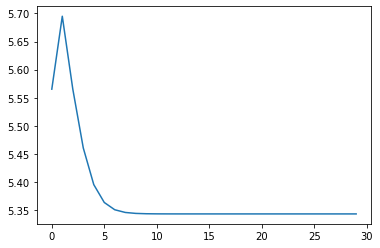

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# 折れ線グラフを出力
height = plot_E
left = range(30)
plt.plot(left, height)

# 終わり

In [ ]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-04-27 07:42:10.951671+09:00
total_time= 0:00:01.176582
